## Load data

In [196]:
import pandas as pd

query_log = pd.read_excel("./data/query_log_IT.xlsx")
query_log.head()

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,C
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,NC
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,C


In [197]:
# merged_df = pd.read_excel("./output/analysed_data.xlsx")

query_log["relevant_click"] = ["/".join([row["relevant"], row["click"]]) for _, row in query_log.iterrows()]
query_log.to_excel("./data/query_log_IT.xlsx", index=False)
query_log.head(2)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click,relevant_click
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC,R/NC
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC,NR/NC


## Computing anaysis metrics

### textstat

In [198]:
import textstat
import textcomplexity

textstat.set_lang('it')

merged_df = query_log

merged_df["fre"] = [round(textstat.flesch_reading_ease(text),2) for text in merged_df["text_sample"]]
merged_df["gulpease_index"] = [round(textstat.gulpease_index(text),2) for text in merged_df["text_sample"]]
merged_df["num_words"] = [textstat.lexicon_count(text_sample) for text_sample in merged_df["text_sample"]]
merged_df["num_sentences"] = [textstat.sentence_count(text_sample) for text_sample in merged_df["text_sample"]]
merged_df["avg_sent_len"] = [round(row["num_words"]/row["num_sentences"],2) for _, row in merged_df.iterrows()]
merged_df["reading_time"] = [round(textstat.reading_time(text_sample),2) for text_sample in merged_df["text_sample"]] # reading time in seconds
merged_df.to_excel("./output/analysed_data.xlsx", index=False)
merged_df.head(5)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click,relevant_click,fre,gulpease_index,num_words,num_sentences,avg_sent_len,reading_time
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC,R/NC,16.44,47.39,80,9,8.89,9.30
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC,NR/NC,42.43,46.09,52,2,26.00,4.32
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,C,R/C,65.01,51.18,69,4,17.25,5.76
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,NC,NR/NC,54.92,53.26,47,4,11.75,4.23
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,C,R/C,33.87,39.05,41,3,13.67,4.44


### emotions using FEEL-IT

In [199]:
from transformers import pipeline
import pandas as pd
from tqdm.notebook import tqdm
import re

tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
emo_classifier = pipeline("text-classification",model='MilaNLProc/feel-it-italian-emotion',top_k=4)
sent_classifier = pipeline("text-classification",model='MilaNLProc/feel-it-italian-sentiment',top_k=2)


def clean_text(text):
    # text = re.sub("(\s?\n){1,}", ".", text) # remove new lines and replace with .
    # text = re.sub("\t{1,}", " ", text) # remove tab spaces and replace with a singular space
    # text = re.sub("[^\w\-(\.{1})'\!\?]", " ", text) # remove non-alphanumeric symbols, except for ., ', !, -
    # text = re.sub("[\(\)\[\]\{\}]", "", text) # remove brackets of any kind
    # text = re.sub("\s{2,}", " ", text) # remove any multiple white spaces
    # text = text.strip() # remove any leading or ending white spaces
    return text

def get_semantic_EP(texts, text_name):
    cleaned_texts = [clean_text(text) for text in texts]
    cleaned_text_name = text_name+"_cleaned"
    try:
        emo_scores = emo_classifier(cleaned_texts)
        sent_scores = sent_classifier(cleaned_texts)
    except:
        emo_scores = emo_classifier(cleaned_texts, **tokenizer_kwargs)
        sent_scores = sent_classifier(cleaned_texts, **tokenizer_kwargs)

    EP_semantic_results = {
        text_name: [],
        cleaned_text_name: [],
        "positive": [],
        "negative": [],
        "joy": [],
        "sadness": [],
        "anger": [],
        "fear": [],
    }

    for text, cleaned_text, sent_score, emo_score in tqdm(zip(texts, cleaned_texts, sent_scores, emo_scores), total=len(cleaned_texts)):
        EP_semantic_results[text_name].append(text)
        EP_semantic_results[cleaned_text_name].append(cleaned_text)
        for sent_dict in sent_score:
            EP_semantic_results[sent_dict["label"]].append(sent_dict["score"]*100)
        for emo_dict in emo_score:
            EP_semantic_results[emo_dict["label"]].append(emo_dict["score"]*100)
    df = pd.DataFrame.from_dict(EP_semantic_results)
    return cleaned_text_name, df

Device set to use cpu
Device set to use cpu


In [200]:
col_name, df = get_semantic_EP(query_log["text_sample"], "text_sample")

  0%|          | 0/670 [00:00<?, ?it/s]

In [201]:
df

,text_sample,text_sample_cleaned,positive,negative,joy,sadness,anger,fear
0,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione - ecoage.it C...,0.021162,99.978834,0.030134,28.261167,2.296164,69.412529
1,La deforestazione in Amazzonia - Foresta Amazz...,La deforestazione in Amazzonia - Foresta Amazz...,0.021949,99.978048,0.013760,98.607928,0.930574,0.447741
2,Le conseguenze degli incendi della foresta ama...,Le conseguenze degli incendi della foresta ama...,0.021432,99.978572,0.075051,0.677358,0.068005,99.179584
3,Cause e conseguenze della deforestazione ambie...,Cause e conseguenze della deforestazione ambie...,0.021079,99.978918,0.171767,13.405944,0.061931,86.360347
4,Conseguenze della deforestazione - eniscuola.n...,Conseguenze della deforestazione - eniscuola.n...,0.021262,99.978739,0.023688,91.533715,1.289659,7.152940
...,...,...,...,...,...,...,...,...
665,Pacifico: l'isola di plastica Ã¨ sempre piÃ¹ e...,Pacifico: l'isola di plastica Ã¨ sempre piÃ¹ e...,0.022558,99.977440,0.562808,98.936266,0.031969,0.468954
666,"Isola di plastica del Pacifico, pulirla non ri...","Isola di plastica del Pacifico, pulirla non ri...",0.024205,99.975795,0.031681,92.709023,2.448528,4.810774
667,Pacific Trash Vortex - Wikipedia. Il Pacific T...,Pacific Trash Vortex - Wikipedia. Il Pacific T...,0.022255,99.977750,0.011395,1.538603,97.937590,0.512417
668,PlasticitÃ (arte) - Wikipedia. Scultura. L'ar...,PlasticitÃ (arte) - Wikipedia. Scultura. L'ar...,99.430555,0.569448,64.009309,25.706846,9.110057,1.173787


In [202]:
merged_df

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click,relevant_click,fre,gulpease_index,num_words,num_sentences,avg_sent_len,reading_time
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC,R/NC,16.44,47.39,80,9,8.89,9.30
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC,NR/NC,42.43,46.09,52,2,26.00,4.32
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,C,R/C,65.01,51.18,69,4,17.25,5.76
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,NC,NR/NC,54.92,53.26,47,4,11.75,4.23
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,C,R/C,33.87,39.05,41,3,13.67,4.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,500,CosÃƒÂ¨ Ã„Â¾isola di plastica,https://www.repubblica.it/ambiente/2018/03/22/...,Pacifico: l'isola di plastica Ã¨ sempre piÃ¹ e...,"NON ci si puÃ² ancora piantare lâ€™ombrellone,...",Pacifico: l'isola di plastica Ã¨ sempre piÃ¹ e...,"['Pacifico', ':', ""l'isola"", 'di', 'plastica',...","[('Pacifico', 'NN'), (':', ':'), (""l'isola"", '...",6,R,C,R/C,85.14,67.57,41,4,10.25,3.20
666,500,CosÃƒÂ¨ Ã„Â¾isola di plastica,http://www.nationalgeographic.it/ambiente/2018...,"Isola di plastica del Pacifico, pulirla non ri...",La cosiddetta Isola di plastica del Pacifico (...,"Isola di plastica del Pacifico, pulirla non ri...","['Isola', 'di', 'plastica', 'del', 'Pacifico',...","[('Isola', 'NNP'), ('di', 'NN'), ('plastica', ...",7,NR,NC,NR/NC,61.17,51.33,55,3,18.33,4.52
667,500,CosÃƒÂ¨ Ã„Â¾isola di plastica,https://it.wikipedia.org/wiki/Pacific_Trash_Vo...,Pacific Trash Vortex - Wikipedia,"Il Pacific Trash Vortex, noto anche come grand...",Pacific Trash Vortex - Wikipedia. Il Pacific T...,"['Pacific', 'Trash', 'Vortex', '-', 'Wikipedia...","[('Pacific', 'NNP'), ('Trash', 'NNP'), ('Vorte...",8,NR,NC,NR/NC,43.78,42.23,58,2,29.00,4.95
668,500,CosÃƒÂ¨ Ã„Â¾isola di plastica,https://it.wikipedia.org/wiki/Plasticit%C3%A0_...,PlasticitÃ (arte) - Wikipedia,Scultura. L'arte plastica per eccellenza Ã¨ la...,PlasticitÃ (arte) - Wikipedia. Scultura. L'ar...,"['PlasticitÃ ', '(', 'arte', ')', '-', 'Wikipe...","[('PlasticitÃ ', 'NNP'), ('(', '('), ('arte', ...",9,NR,NC,NR/NC,48.00,44.65,60,3,20.00,5.41


In [203]:
merged_df = pd.merge(merged_df, df, on="text_sample")
merged_df.drop(["text_sample_cleaned"], axis=1, inplace=True)
merged_df.drop_duplicates(inplace=True, ignore_index=True)
merged_df.to_excel("./output/analysed_data.xlsx", index=False)
merged_df.head(5)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,...,num_words,num_sentences,avg_sent_len,reading_time,positive,negative,joy,sadness,anger,fear
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,...,80,9,8.89,9.30,0.021162,99.978834,0.030134,28.261167,2.296164,69.412529
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,...,52,2,26.00,4.32,0.021949,99.978048,0.013760,98.607928,0.930574,0.447741
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,...,69,4,17.25,5.76,0.021432,99.978572,0.075051,0.677358,0.068005,99.179584
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,...,47,4,11.75,4.23,0.021079,99.978918,0.171767,13.405944,0.061931,86.360347
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,...,41,3,13.67,4.44,0.021262,99.978739,0.023688,91.533715,1.289659,7.152940


In [204]:
len(merged_df)

670

In [205]:
merged_df["sentiment_max"] = [max(row["positive"], row["negative"]) for _, row in merged_df.iterrows()]
merged_df.to_excel("./output/analysed_data.xlsx", index=False)
merged_df.head(2)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,...,num_sentences,avg_sent_len,reading_time,positive,negative,joy,sadness,anger,fear,sentiment_max
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,...,9,8.89,9.30,0.021162,99.978834,0.030134,28.261167,2.296164,69.412529,99.978834
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,...,2,26.00,4.32,0.021949,99.978048,0.013760,98.607928,0.930574,0.447741,99.978048


In [206]:
len(merged_df)

670

### textcomplexity

In [132]:
!python textcomplexity/utils/run_stanza.py --language "it" "./data/text_samples.tsv"


2025-10-21 13:04:43 INFO: Downloaded file to C:\Users\hrishitachakra\stanza_resources\resources.json
2025-10-21 13:04:43 INFO: Downloading default packages for language: it (Italian) ...
2025-10-21 13:04:46 INFO: File exists: C:\Users\hrishitachakra\stanza_resources\it\default.zip
2025-10-21 13:04:54 INFO: Finished downloading models and saved to C:\Users\hrishitachakra\stanza_resources
2025-10-21 13:04:54 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES

2025-10-21 13:04:54 INFO: Downloaded file to C:\Users\hrishitachakra\stanza_resources\resources.json
2025-10-21 13:04:56 INFO: Loading these models for language: it (Italian):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | 

In [137]:
!python textcomplexity/bin/txtcomplexity --input-format conllu "text_samples.tsv.conllu"

Traceback (most recent call last):
  File "c:\Users\hrishitachakra\OneDrive - Delft University of Technology\Documents\SOL\Projects\ECIR'26\IR4Good2026\textcomplexity\bin\txtcomplexity", line 12, in <module>
    textcomplexity.cli.main()
  File "c:\Users\hrishitachakra\AppData\Local\anaconda3\envs\ir_env\lib\site-packages\textcomplexity\cli.py", line 202, in main
    results.extend(surface_based(tokens, args.window_size, args.preset))
  File "c:\Users\hrishitachakra\AppData\Local\anaconda3\envs\ir_env\lib\site-packages\textcomplexity\cli.py", line 72, in surface_based
    mean, stdev, _ = misc.bootstrap(measure, tokens, window_size, strategy="spread")
  File "c:\Users\hrishitachakra\AppData\Local\anaconda3\envs\ir_env\lib\site-packages\textcomplexity\utils\misc.py", line 72, in bootstrap
    for window in windows.disjoint_windows(tokens, window_size, strategy):
  File "c:\Users\hrishitachakra\AppData\Local\anaconda3\envs\ir_env\lib\site-packages\textcomplexity\utils\windows.py", line 3

### Subjective Objective

Using the [model](https://huggingface.co/GroNLP/mdebertav3-subjectivity-italian) from the [winners](https://research.rug.nl/en/publications/thesis-titan-at-checkthat-2023-language-specific-fine-tuning-of-m) of Task 2 (Subjectivity Detection) at CLEF 2023

In [207]:
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("text-classification", model="GroNLP/mdebertav3-subjectivity-italian", top_k = 2)
# LABEL_0: OBJ
# LABEL_1: SUBJ

def get_subj_obj_probs(texts, text_col_name):
    preds = pipe(texts)
    label_map = {
        "LABEL_0": "OBJ",
        "LABEL_1": "SUBJ"
    }

    scores = {
        text_col_name: [],
        "OBJ": [],
        "SUBJ": []
    }

    for text, results in zip(texts, preds):
        # print(results)
        scores[text_col_name].append(text)
        for result in results:
            label = result["label"]
            score = result["score"]
            scores[label_map[label]].append(score)


    df = pd.DataFrame.from_dict(scores)
    return df


Device set to use cpu


In [208]:
text_examples= [
    "La donna aveva una bandiera pro Trump e dopo essere stata colpita è caduta a terra.", #OBJ
    "Quando questi bisogni vengono minacciati allora è il momento di ridefinire tutta la nostra esistenza con un reset totale.", #SUBJ
    "Se, come pare plausibile, almeno 5 milioni di lavoratori resteranno in smart working anche dopo la pandemia, ciò determinerà un crollo dei consumi di abitazioni, di carburante, di mezzi di comunicazione e il licenziamento di migliaia di addetti alla guardiania e alle pulizie degli uffici, alle mense aziendali e ai negozi proliferati nelle zone direzionali.", #OBJ
    "TUTTO ALL'INSEGNA DELLA BUONA BATTAGLIA.", #SUBJ,
    "E ieri sono state arrestate altre 350 persone vicino al tribunale," #OBJ
]

get_subj_obj_probs(texts=text_examples, text_col_name="text_sample")

,text_sample,OBJ,SUBJ
0,La donna aveva una bandiera pro Trump e dopo e...,0.970240,0.029759
1,Quando questi bisogni vengono minacciati allor...,0.054733,0.945267
2,"Se, come pare plausibile, almeno 5 milioni di ...",0.832746,0.167254
3,TUTTO ALL'INSEGNA DELLA BUONA BATTAGLIA.,0.079547,0.920453
4,E ieri sono state arrestate altre 350 persone ...,0.976517,0.023483


In [209]:
subj_df = get_subj_obj_probs(texts=list(merged_df["text_sample"]), text_col_name = "text_sample")
subj_df

,text_sample,OBJ,SUBJ
0,Conseguenze della deforestazione - ecoage.it C...,0.506412,0.493588
1,La deforestazione in Amazzonia - Foresta Amazz...,0.953187,0.046813
2,Le conseguenze degli incendi della foresta ama...,0.964282,0.035718
3,Cause e conseguenze della deforestazione ambie...,0.084439,0.915561
4,Conseguenze della deforestazione - eniscuola.n...,0.641711,0.358289
...,...,...,...
665,Pacifico: l'isola di plastica Ã¨ sempre piÃ¹ e...,0.816914,0.183086
666,"Isola di plastica del Pacifico, pulirla non ri...",0.796627,0.203373
667,Pacific Trash Vortex - Wikipedia. Il Pacific T...,0.955169,0.044830
668,PlasticitÃ (arte) - Wikipedia. Scultura. L'ar...,0.643141,0.356859


In [210]:
merged_df = pd.merge(merged_df, subj_df, on="text_sample")
merged_df.drop_duplicates(ignore_index=True, inplace=True)
merged_df.to_excel("./output/analysed_data.xlsx", index=False)
merged_df.head(5)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,...,reading_time,positive,negative,joy,sadness,anger,fear,sentiment_max,OBJ,SUBJ
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,...,9.30,0.021162,99.978834,0.030134,28.261167,2.296164,69.412529,99.978834,0.506412,0.493588
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,...,4.32,0.021949,99.978048,0.013760,98.607928,0.930574,0.447741,99.978048,0.953187,0.046813
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,...,5.76,0.021432,99.978572,0.075051,0.677358,0.068005,99.179584,99.978572,0.964282,0.035718
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,...,4.23,0.021079,99.978918,0.171767,13.405944,0.061931,86.360347,99.978918,0.084439,0.915561
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,...,4.44,0.021262,99.978739,0.023688,91.533715,1.289659,7.152940,99.978739,0.641711,0.358289


In [211]:
len(merged_df)

670

### hate speech using [HATE-ITA](https://huggingface.co/MilaNLProc/hate-ita)

In [193]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="MilaNLProc/hate-ita-xlm-r-large", top_k = 2)

def hate_pred(texts, text_col_name):
    scores = {
        text_col_name: [],
        "hateful": [],
        "non-hateful": []
    }

    preds = pipe(texts)

    for text, results in zip(texts, preds):
        scores[text_col_name].append(text)
        for result in results:
            scores[result["label"]] = result["score"]

    df = pd.DataFrame.from_dict(scores)
    return df

config.json: 0.00B [00:00, ?B/s]

c:\Users\hrishitachakra\AppData\Local\anaconda3\envs\ir_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hrishitachakra\.cache\huggingface\hub\models--MilaNLProc--hate-ita-xlm-r-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is no

WARNING: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


WARNING: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


WARNING: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


WARNING: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [195]:
hate_df = hate_pred(texts = list(merged_df["text_sample"]), text_col_name = "text_sample")
hate_df.drop_duplicates(inplace=True, ignore_index=True)
hate_df

,text_sample,hateful,non-hateful
0,Conseguenze della deforestazione - ecoage.it C...,0.226887,0.773113
1,La deforestazione in Amazzonia - Foresta Amazz...,0.226887,0.773113
2,Le conseguenze degli incendi della foresta ama...,0.226887,0.773113
3,Cause e conseguenze della deforestazione ambie...,0.226887,0.773113
4,Conseguenze della deforestazione - eniscuola.n...,0.226887,0.773113
...,...,...,...
531,Un altissimo campo di battaglia - ItaliaOggi.i...,0.226887,0.773113
532,Il destino dei ghiacciai di montagna nellâ€™An...,0.226887,0.773113
533,"Le isole di plastica, un mare di plastica | Cu...",0.226887,0.773113
534,PlasticitÃ (arte) - Wikipedia. Scultura. L'ar...,0.226887,0.773113


In [190]:
merged_df = pd.merge(merged_df, hate_df, on="text_sample")
merged_df.drop_duplicates(inplace=True, ignore_index=True)
merged_df.to_excel("./output/analysed_data.xlsx", index=False)
merged_df.head(5)

,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,...,negative,joy,sadness,anger,fear,sentiment_max,OBJ,SUBJ,hateful,non-hateful
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,...,99.978834,0.030134,28.261167,2.296164,69.412529,99.978834,0.506412,0.493588,0.854594,0.145406
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,...,99.978048,0.013760,98.607928,0.930574,0.447741,99.978048,0.953187,0.046813,0.854594,0.145406
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli...",3,R,...,99.978572,0.075051,0.677358,0.068005,99.179584,99.978572,0.964282,0.035718,0.854594,0.145406
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'...",4,NR,...,99.978918,0.171767,13.405944,0.061931,86.360347,99.978918,0.084439,0.915561,0.854594,0.145406
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",5,R,...,99.978739,0.023688,91.533715,1.289659,7.152940,99.978739,0.641711,0.358289,0.854594,0.145406


In [191]:
len(merged_df)

728

## Stats

In [220]:
metrics = ['fre', 'gulpease_index', 'num_words',
       'num_sentences', 'avg_sent_len', 'reading_time', 'positive', 'negative',
       'joy', 'sadness', 'anger', 'fear', 'sentiment_max', 'OBJ', 'SUBJ']

merged_df.groupby(["relevant"])[metrics].mean().reset_index()

,relevant,fre,gulpease_index,num_words,num_sentences,avg_sent_len,reading_time,positive,negative,joy,sadness,anger,fear,sentiment_max,OBJ,SUBJ
0,NR,68.128406,55.899705,50.842288,3.351820,16.404107,4.140919,42.590461,57.409539,36.099327,34.710801,11.48888,17.700992,98.984761,0.706093,0.293907
1,R,70.480000,56.526774,70.204301,4.709677,16.144624,5.617097,33.061839,66.938162,33.280765,39.349799,7.38215,19.987287,99.334675,0.686289,0.313711


## Visualisations

In [223]:
import pandas as pd

merged_df = pd.read_excel("./output/analysed_data.xlsx")
merged_df.columns

Index(['session_id', 'query', 'url', 'title', 'snippet', 'text_sample',
       'text_sample_tokens', 'text_sample_pos', 'position', 'relevant',
       'click', 'relevant_click', 'fre', 'gulpease_index', 'num_words',
       'num_sentences', 'avg_sent_len', 'reading_time', 'positive', 'negative',
       'joy', 'sadness', 'anger', 'fear', 'sentiment_max', 'OBJ', 'SUBJ'],
      dtype='object')

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualise_metric(metric, metric_label):
    merged_df = pd.read_excel("./output/analysed_data.xlsx")
    g = sns.boxplot(data = merged_df, y=metric, x="click")
    g.set_ylabel(metric_label)
    g.set_xlabel("")
    file_name = metric+"_click.pdf"
    plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
    plt.show()

    g = sns.boxplot(data = merged_df, y=metric, x="relevant")
    g.set_ylabel(metric_label)
    g.set_xlabel("")
    file_name = metric+"_relevant.pdf"
    plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
    plt.show()

    g = sns.boxplot(data = merged_df, y=metric, x="relevant_click")
    g.set_ylabel(metric_label)
    g.set_xlabel("")
    file_name = metric+"_relevant_click.pdf"
    plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
    plt.show()

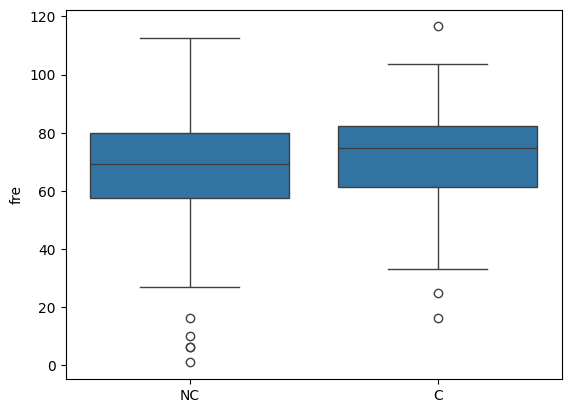

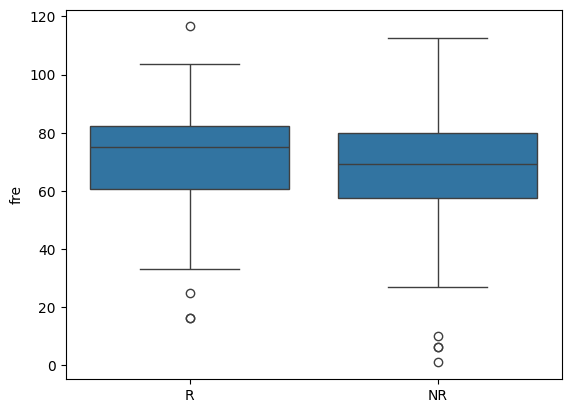

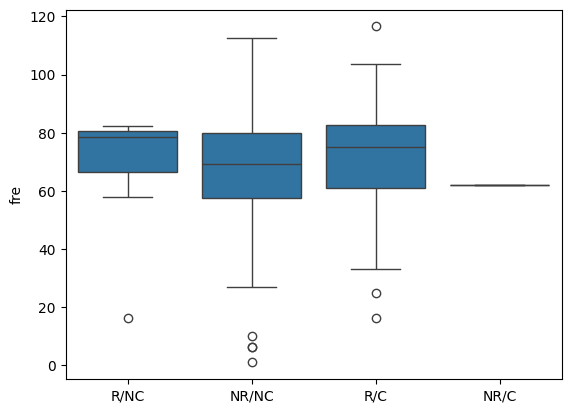

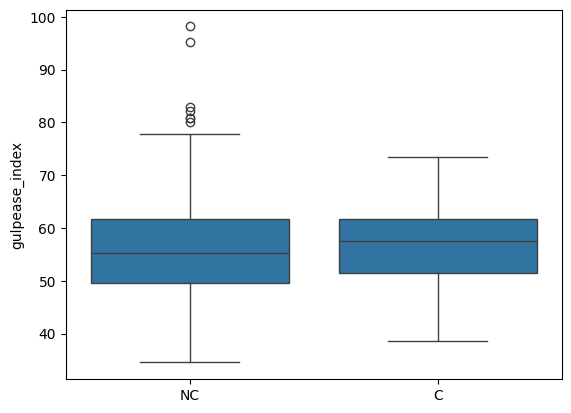

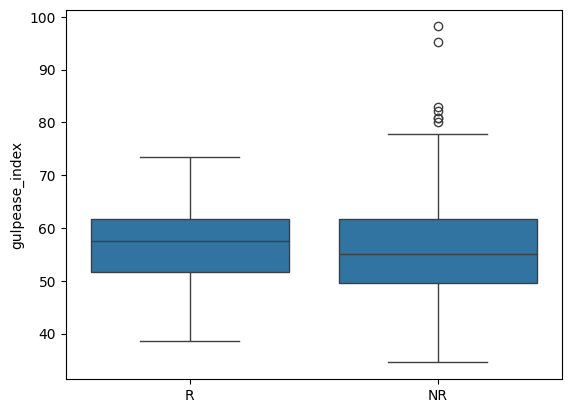

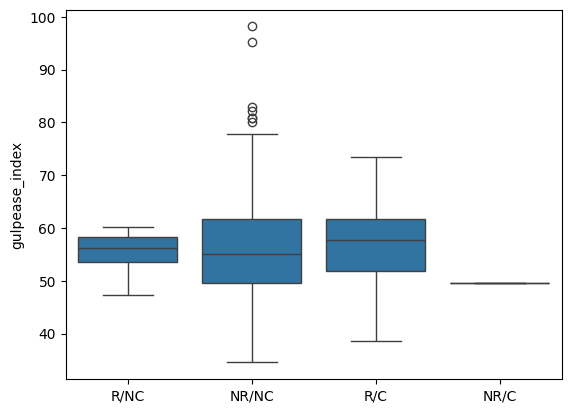

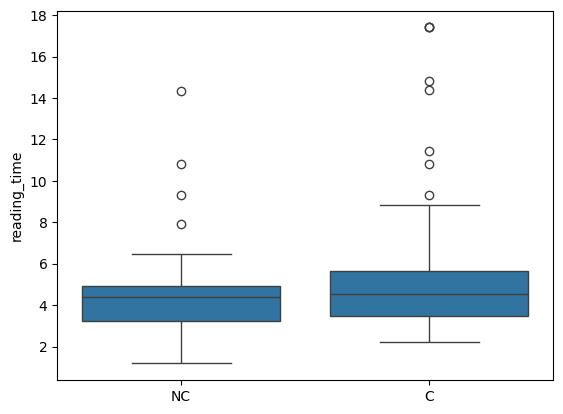

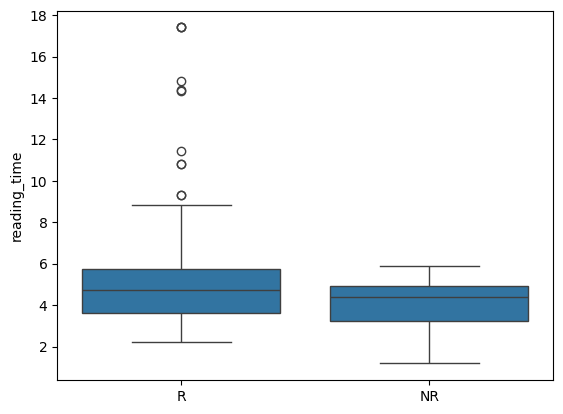

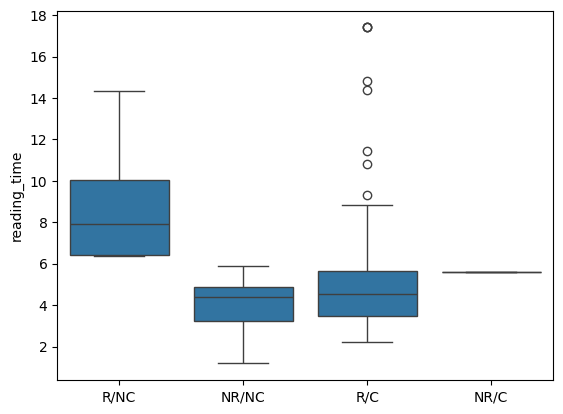

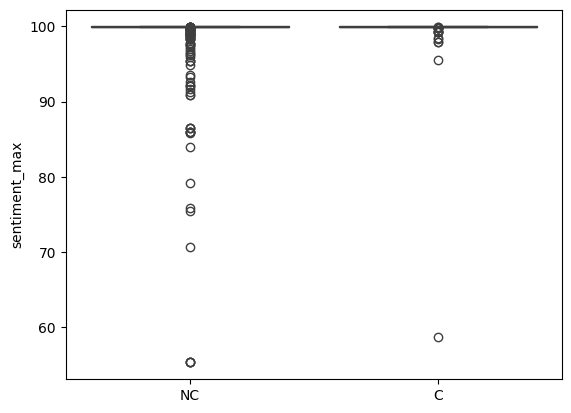

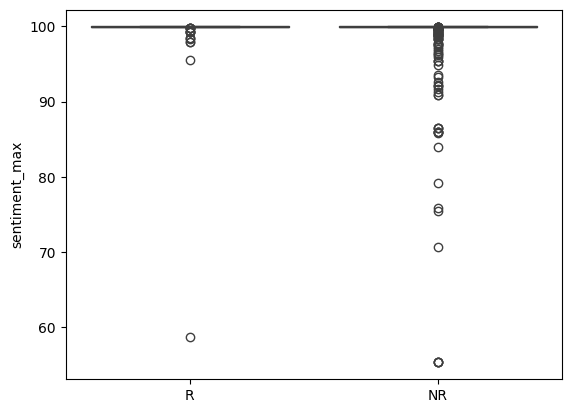

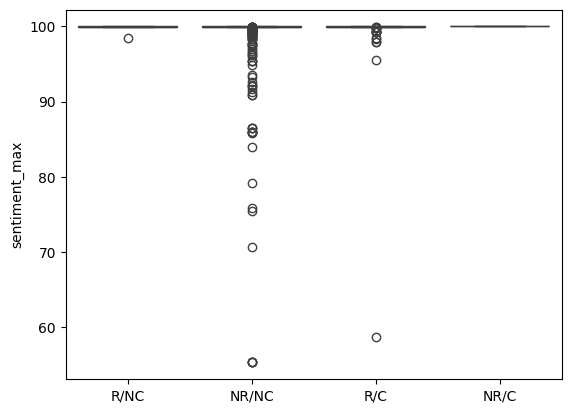

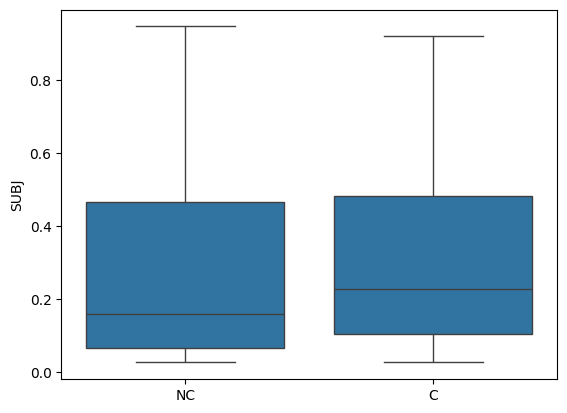

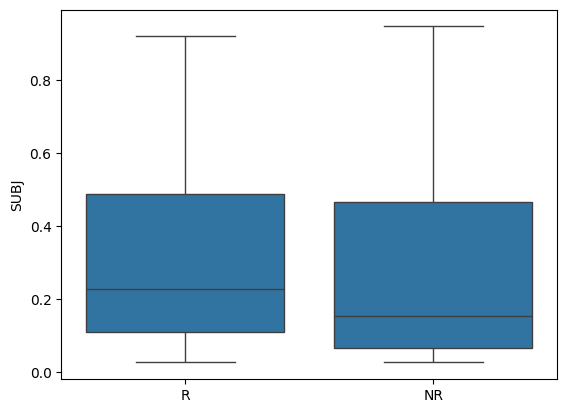

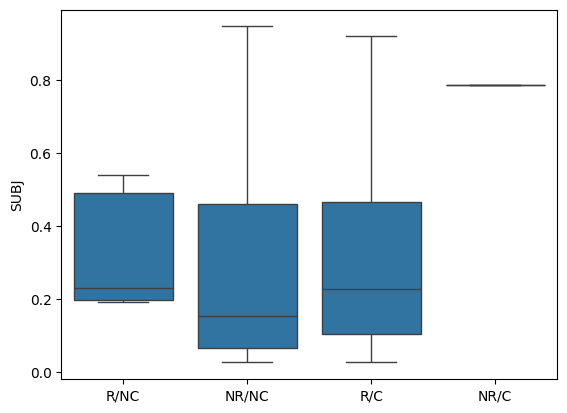

In [230]:
reported_metrics = ['fre', 'gulpease_index', 'reading_time', 'sentiment_max', 'SUBJ']

for metric in reported_metrics:
    visualise_metric(metric=metric, metric_label=metric)